# Sales Prediction Using Python

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# loading data
data =pd.read_csv(r"C:\Users\RBI\Downloads\Advertising.csv",index_col=0,header=0)
data.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [3]:
print(data.dtypes)
print(data.shape)
print(data.describe())

TV           float64
radio        float64
newspaper    float64
sales        float64
dtype: object
(200, 4)
               TV       radio   newspaper       sales
count  200.000000  200.000000  200.000000  200.000000
mean   147.042500   23.264000   30.554000   14.022500
std     85.854236   14.846809   21.778621    5.217457
min      0.700000    0.000000    0.300000    1.600000
25%     74.375000    9.975000   12.750000   10.375000
50%    149.750000   22.900000   25.750000   12.900000
75%    218.825000   36.525000   45.100000   17.400000
max    296.400000   49.600000  114.000000   27.000000


We will not be doing feature selection (i.e elimination of variables) since all variables are imp from domin point of view.

In [4]:
# checking missing values 

data.isnull().sum()

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

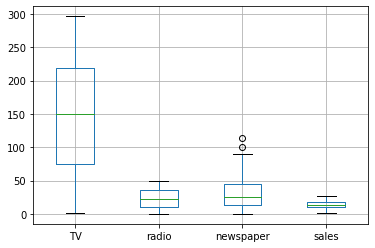

In [5]:
data.boxplot()

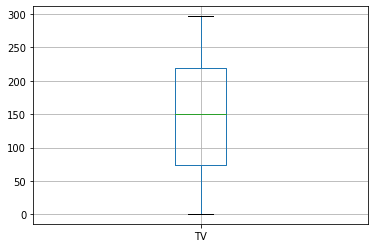

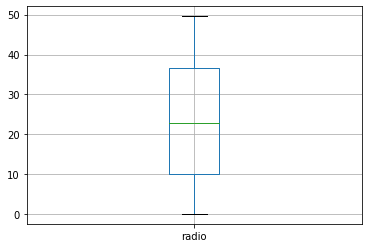

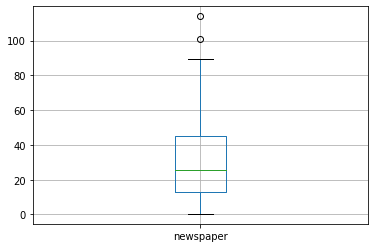

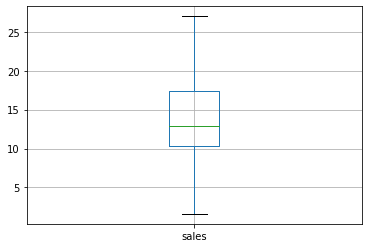

In [6]:
# Assumption 1: There should be no outlier in the data
# check using boxplot

for i in data.columns:
    data.boxplot(column=i)
    plt.show()

It is observed that newspaper has few outliers which can be eliminated before we move on

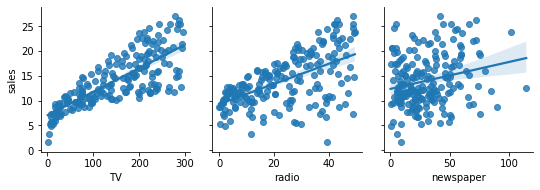

In [7]:
# Assumption 2: Assumption of Linearity: Every indpendent variable should have a linear relationship with the dependent variable

sns.pairplot(data,x_vars=['TV','radio','newspaper'],
            y_vars=['sales'],kind='reg')                    
plt.show()

We observe that newspaper does not show a relationship with the sales variables. So we can eliminate the newspaper variable and preceed with TV and Radio since they show a linear relationship with the sales variable.

In [8]:
data.columns

Index(['TV', 'radio', 'newspaper', 'sales'], dtype='object')

In [9]:
# create X and Y
X = data.loc[:,['TV','radio','newspaper']]
Y = data.loc[:,"sales"]

In [10]:
print(X.shape)
print(Y.shape)

(200, 3)
(200,)


In [11]:
import warnings
warnings.filterwarnings('ignore')

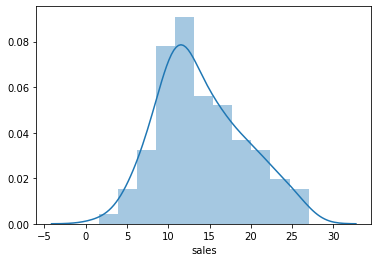

In [12]:
# Assumption of Normality 3: The dependent variable should follow on apporoximate normal distrubution
sns.distplot(Y)
plt.show()

The data is normally distributed.

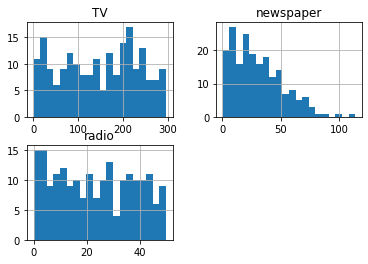

In [13]:
X.hist(bins=20)        # to view the histogram of all the 3 varables
plt.show()

In [14]:
# checking skewnwess 
from scipy.stats import skew
#finding the skewness in each variable
data_num_skew = X.apply(lambda i: skew(i.dropna()))       

#subsetting the variables that are highly skewed
data_num_skewed = data_num_skew[(data_num_skew > .75) | (data_num_skew < -.75)]
 
print(data_num_skew)
print(data_num_skewed)

import numpy as np
X['newspaper'] = np.log1p(X['newspaper'])   

TV          -0.069328
radio        0.093467
newspaper    0.887996
dtype: float64
newspaper    0.887996
dtype: float64


If the variable consists of 0 value then log 0 will become -infinity which will throw error while building the model. In such case we can use log +1 transformation to avoid the -inf problem.

                 TV     radio  newspaper
TV         1.000000  0.054809   0.030951
radio      0.054809  1.000000   0.251909
newspaper  0.030951  0.251909   1.000000


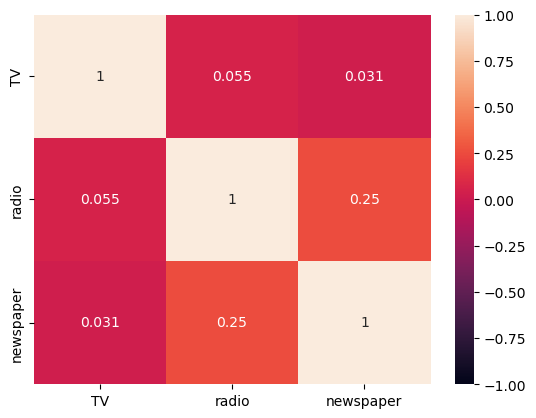

In [19]:
# Assumption of no multicollinearity 4: 
corr_df=X.corr(method="pearson")
print(corr_df)
 
sns.heatmap(corr_df,vmax=1.0,vmin=-1.0,annot=True)
plt.show()


In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
 
vif_df = pd.DataFrame()
vif_df["features"] = X.columns
vif_df["VIF Factor"] = [vif(X.values, i) for i in range(X.shape[1])]
vif_df.round(2)

,features,VIF Factor
0,TV,3.39
1,radio,3.63
2,newspaper,5.44


Even tough VIF factor for newspaper is high we will not eliminate it as it is an important variable.

In [22]:
#Split the data into test and train
from sklearn.model_selection import train_test_split 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,     
                                                    random_state=10)         

In [23]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


(160, 3)
(160,)
(40, 3)
(40,)


In [25]:
# Applying Linear Regression Model (Base Model)

from sklearn.linear_model import LinearRegression

# create a model object
lm = LinearRegression()

# train the model object
lm.fit(X_train, Y_train)            
# print intercept and coefficients
print(lm.intercept_)                     
print(lm.coef_)                           


3.3532913858151545
[ 0.0437425   0.19303708 -0.04895137]


In [26]:
# pair the feature names with the coefficients 
print(list(zip(X.columns, lm.coef_)))

[('TV', 0.04374250157742164), ('radio', 0.19303707897345296), ('newspaper', -0.04895136822248787)]


In [28]:
# predict using the model  
Y_pred=lm.predict(X_test)
print(Y_pred)                          

[18.15026866 12.96136899 18.05815332 23.66025079 20.68751041 14.26325872
 14.92774472 21.38847375 21.14752911 12.75788534 23.99735583  7.20632737
 12.30777109 19.22813333 19.41581583 13.44985803 19.62619644  9.24667496
 21.1052867  20.87838433 15.52611251 10.91695579 22.82910679 15.82915597
 17.40742204  8.17170435 11.88738387 12.69866637 21.71275044  7.94920205
 12.49118989 20.43292079  4.71443086  4.72126238 16.7504848  15.74384945
  6.74775596 17.73750244  9.01170001 13.60841593]


In [29]:
new_df=pd.DataFrame()
new_df=X_test.copy()
 
new_df["Actual sales"]=Y_test
new_df["Predicted sales"]=Y_pred
new_df=new_df.reset_index().drop('index',axis=1)

In [30]:
new_df

,TV,radio,newspaper,Actual sales,Predicted sales
0,210.7,29.5,2.332144,18.4,18.150269
1,8.7,48.9,4.330733,7.2,12.961369
2,218.4,27.7,3.996364,18.0,18.058153
3,283.6,42.0,4.207673,25.5,23.660251
4,216.4,41.7,3.703768,22.6,20.687510
5,147.3,23.9,3.000720,14.6,14.263259
6,188.4,18.1,3.280911,14.9,14.927745
7,198.9,49.4,4.110874,23.7,21.388474
8,216.8,43.9,3.339322,22.3,21.147529
9,17.2,45.9,4.252772,9.3,12.757885


In [33]:
from sklearn.metrics import r2_score,mean_squared_error
import numpy as np
 
r2=r2_score(Y_test,Y_pred)
print("R-squared:",r2)
 
rmse=np.sqrt(mean_squared_error(Y_test,Y_pred))
print("RMSE:",rmse)
 
adjusted_r_squared = 1 - (1-r2)*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print("Adj R-square:",adjusted_r_squared)

R-squared: 0.8348010719035319
RMSE: 2.5929769110930603
Adj R-square: 0.8322725168816472


R-squared value is close to 1.  
RMSE is low.
Adj R-square is also close to r-square.
Therefore it is a good model

## Tunning

### Ridge

In [35]:
from sklearn.model_selection import train_test_split
 
#Split the data into test and train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,      
                                                    random_state=10)    

In [37]:
from sklearn.linear_model import Ridge

# create a model object
rid = Ridge()

# train the model object
rid.fit(X_train, Y_train)           

# print intercept and coefficients
print(rid.intercept_)                     
print(rid.coef_)           


3.3522471725965985
[ 0.04374234  0.19302603 -0.04853131]


In [38]:
Y_pred=rid.predict(X_test)     # training the X test on RIDGE model

In [39]:
from sklearn.metrics import r2_score,mean_squared_error
import numpy as np
 
r2=r2_score(Y_test,Y_pred)
print("R-squared:",r2)
 
rmse=np.sqrt(mean_squared_error(Y_test,Y_pred))
print("RMSE:",rmse)
 
adjusted_r_squared = 1 - (1-r2)*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print("Adj R-square:",adjusted_r_squared)


R-squared: 0.8348082644975935
RMSE: 2.5929204626839977
Adj R-square: 0.8322798195664342


R-squared value is close to 1.

RMSE is low. Adj R-square is also close to r-square. Therefore it is a good model.

### LASSO

In [41]:
#Split the data into test and train

from sklearn.model_selection import train_test_split 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,      
                                                    random_state=10)    

In [43]:
from sklearn.linear_model import Lasso

# create a model object
las = Lasso()

# train the model object
las.fit(X_train, Y_train)           

# print intercept and coefficients
print(las.intercept_)                    
print(las.coef_)           


3.336794058220317
[ 0.04362374  0.18766033 -0.        ]


In [45]:
Y_pred=las.predict(X_test)

In [46]:
from sklearn.metrics import r2_score,mean_squared_error
import numpy as np
 
r2=r2_score(Y_test,Y_pred)
print("R-squared:",r2)
 
rmse=np.sqrt(mean_squared_error(Y_test,Y_pred))
print("RMSE:",rmse)
 
adjusted_r_squared = 1 - (1-r2)*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print("Adj R-square:",adjusted_r_squared)


R-squared: 0.8360506658527163
RMSE: 2.5831514271094234
Adj R-square: 0.8335412372688292


R-squared value is close to 1.

RMSE is low. Adj R-square is also close to r-square. Therefore it is a good model

### Elastic Net

In [48]:
from sklearn.linear_model import ElasticNet

# create a model object
en = ElasticNet()

# train the model object
en.fit(X_train, Y_train)           

# print intercept and coefficients
print(en.intercept_)                     
print(en.coef_)           


3.286744514338503
[ 0.04367408  0.1895869  -0.        ]


'\nPrevious Value LASSO:\n3.336794058220317\n[ 0.04362374  0.18766033 -0.  \n\n'

In [52]:
Y_pred=en.predict(X_test)

In [51]:
from sklearn.metrics import r2_score,mean_squared_error
import numpy as np
 
r2=r2_score(Y_test,Y_pred)
print("R-squared:",r2)
 
rmse=np.sqrt(mean_squared_error(Y_test,Y_pred))
print("RMSE:",rmse)
 
adjusted_r_squared = 1 - (1-r2)*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print("Adj R-square:",adjusted_r_squared)

R-squared: 0.8358845632451918
RMSE: 2.5844596348220477
Adj R-square: 0.8333725922744549


R-squared value is close to 1.

RMSE is low. Adj R-square is also close to r-square. Therefore it is a good model

# Conclusion

All the model gives the best predction.

All models are good models.

The RMSE values is lowest for Lasso RMSE = 2.5831514271094234